In [1]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

# from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
# from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

# from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
path = "./CEDAR/"

In [3]:
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [4]:
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()
    images = [path+directory+'/'+x for x in images]
    forg_groups.append(images[:24]) # First 24 signatures in each folder are forrged
    orig_groups.append(images[24:]) # Next 24 signatures are genuine

In [5]:
# Quick check to confirm we have data of all the 160 individuals
len(orig_groups), len(forg_groups)

(55, 55)

In [6]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [7]:
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [8]:
print(forg_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [9]:
orig_train, orig_val, orig_test = orig_groups[:35], orig_groups[35:45], orig_groups[45:]
forg_train, forg_val, forg_test = forg_groups[:35], forg_groups[35:45], forg_groups[45:]

In [10]:
del orig_groups, forg_groups

In [11]:
img_h, img_w = 155, 220

In [12]:
def visualize_sample_signature():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

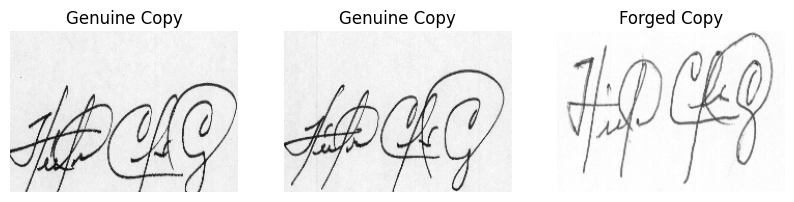

In [13]:
visualize_sample_signature()

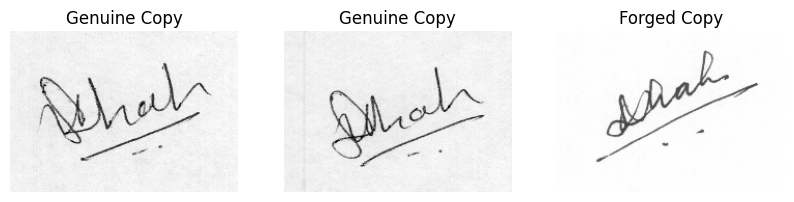

In [14]:
visualize_sample_signature()

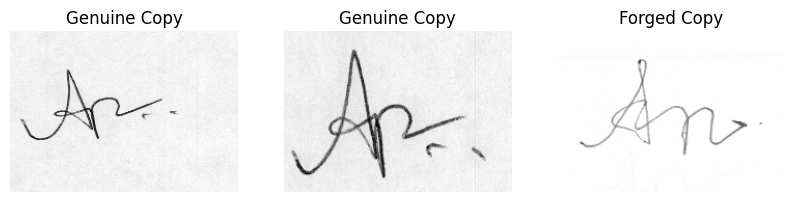

In [15]:
visualize_sample_signature()

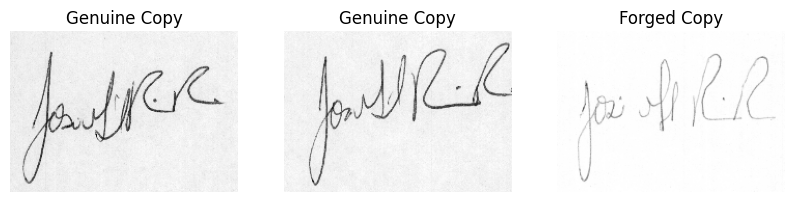

In [16]:
visualize_sample_signature()

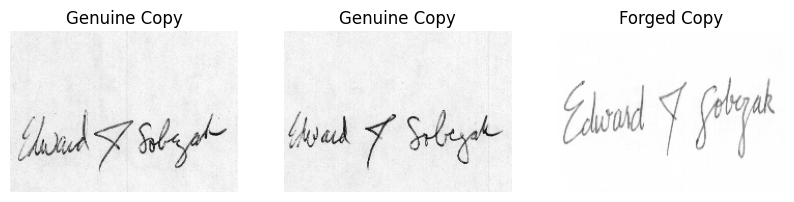

In [17]:
visualize_sample_signature()

In [18]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 120 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 55 * 276 = 15180
        # Total number of Genuine-Forged pairs = 55 * 300 = 16500
        # Total no. of data points = 15180 + 16500 = 31680
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [19]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [20]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [21]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [22]:
from tensorflow.keras.initializers import GlorotUniform

def create_base_network_signet(input_shape):
    seq = Sequential()
    
    # First Conv Layer
    seq.add(Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_1', input_shape=input_shape, kernel_initializer=GlorotUniform()))
    seq.add(MaxPooling2D((2, 2), name='max_pooling2d_1'))
    
    # Second Conv Layer
    seq.add(Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv2d_2', kernel_initializer=GlorotUniform()))
    seq.add(MaxPooling2D((2, 2), name='max_pooling2d_2'))
    
    # Third Conv Layer
    seq.add(Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_3', kernel_initializer=GlorotUniform()))
    seq.add(MaxPooling2D((2, 2), name='max_pooling2d_3'))
    
    # Fourth Conv Layer
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_4', kernel_initializer=GlorotUniform()))
    seq.add(MaxPooling2D((2, 2), name='max_pooling2d_4'))
    
    # Fifth Conv Layer
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_5', kernel_initializer=GlorotUniform()))
    seq.add(MaxPooling2D((2, 2), name='max_pooling2d_5'))
    
    # Sixth Conv Layer
    seq.add(Conv2D(512, kernel_size=(3, 3), activation='relu', name='conv2d_6', kernel_initializer=GlorotUniform()))
    seq.add(MaxPooling2D((2, 2), name='max_pooling2d_6'))
    
    # Flatten and Dense Layers
    seq.add(Flatten(name='flatten_1'))
    seq.add(Dense(256, activation='relu', name='dense_1', kernel_initializer=GlorotUniform()))
    seq.add(Dense(60, activation='softmax', name='dense_2', kernel_initializer=GlorotUniform()))
    
    return seq

In [23]:
input_shape=(img_h, img_w, 1)

In [24]:
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

model.summary()

ValueError: Exception encountered when calling layer "conv2d_6" (type Conv2D).

Negative dimension size caused by subtracting 3 from 2 for '{{node conv2d_6/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_6/Conv2D/ReadVariableOp)' with input shapes: [?,2,4,256], [3,3,256,512].

Call arguments received by layer "conv2d_6" (type Conv2D):
  • inputs=tf.Tensor(shape=(None, 2, 4, 256), dtype=float32)

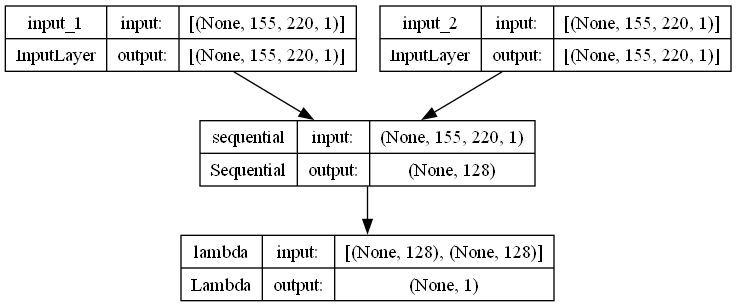

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
batch_sz = 40
num_train_samples = 276*35 + 300*10
num_val_samples = num_test_samples = 276*10 + 300*10
num_train_samples, num_val_samples, num_test_samples

(12660, 5760, 5760)

In [ ]:
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\legacy\rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/signet-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [ ]:
results = model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

C:\Users\User\AppData\Local\Temp\ipykernel_20500\2891634560.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(generate_batch(orig_train, forg_train, batch_sz),


Epoch 1/100
316/316 [==============================] - ETA: 0s - loss: nan
Epoch 1: saving model to ./Weights\signet-bhsig260-001.h5
316/316 [==============================] - 1241s 4s/step - loss: nan - val_loss: nan - lr: 1.0000e-04
Epoch 2/100
316/316 [==============================] - ETA: 0s - loss: nan
Epoch 2: saving model to ./Weights\signet-bhsig260-002.h5
316/316 [==============================] - 1418s 4s/step - loss: nan - val_loss: nan - lr: 1.0000e-04
Epoch 3/100
223/316 [====================>.........] - ETA: 6:36 - loss: nan

KeyboardInterrupt: 

In [ ]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

In [ ]:
model.load_weights('./Weights/signet-bhsig260-009.h5')

In [ ]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [ ]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

In [ ]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()

In [ ]:
predict_score()